# Imports

In [1]:
# Standard libraries
import random
from collections import Counter

# External libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories

In [2]:
## Set Path Here before running the code
WORKING_DIRECTORY =  "./dataset/complete_dataset"

##  Name of classes 
CLASSES = ['glioma',
           'meningioma',
           'no_tumor',
           'pituitary']

# Load, Resacle and One Hot Encoding of imgs

In [3]:
X, y = [], []

## Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)

#   Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, target_size=(170, 170),batch_size=7023, shuffle=True)

### Seperate Dataset from  Data Genrator
X, y = train_dataset.next()

Found 7023 images belonging to 4 classes.


In [4]:
samples_before = len(X)
print("Images shape :\t", X.shape)
print("Labels shape :\t", y.shape)

Images shape :	 (7023, 170, 170, 3)
Labels shape :	 (7023, 4)


In [5]:
#   Number of samples in classes 
print("Number of samples in each class:\t", sorted(Counter(np.argmax(y, axis=1)).items()))

#   class labels as per indices
print("Classes Names according to index:\t", train_dataset.class_indices)

Number of samples in each class:	 [(0, 1621), (1, 1645), (2, 2000), (3, 1757)]
Classes Names according to index:	 {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


# Random samples from dataset

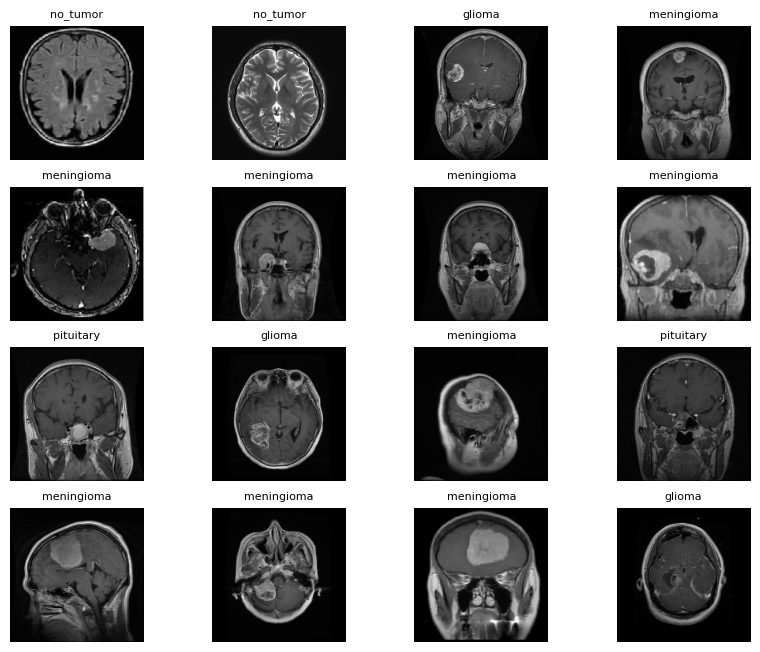

In [6]:
fig = plt.figure(figsize=(10,8))

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(0, len(X)-1 )
    plt.imshow(X[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y[num]))], fontsize=8)
plt.axis('off')
plt.show()

# Split Dataset

In [7]:
#   20% split to validation and 80% split to train set
X_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2)

#   20% split to test from 80% of train and 60% remains in train set
X_train, x_test, y_train, y_test = train_test_split(X_train,y_train, test_size = 0.2)

# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")

print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 1043), (1, 1044), (2, 1301), (3, 1106)]
Validation	 [(0, 316), (1, 341), (2, 381), (3, 367)]
Test      	 [(0, 262), (1, 260), (2, 318), (3, 284)]


In [8]:
del X, y # no more required

# Training and Evaluating Models

# InceptionV3 Model

In [9]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(170, 170, 3))

# Create a new model on top of the base model
InceptionV3_model = Sequential()

InceptionV3_model.add(base_model)

InceptionV3_model.add(Dropout(0.10))

InceptionV3_model.add(Flatten())

InceptionV3_model.add(BatchNormalization())
InceptionV3_model.add(Dense(768, activation='relu'))
InceptionV3_model.add(Dropout(0.30))

InceptionV3_model.add(BatchNormalization())
InceptionV3_model.add(Dense(384, activation='relu'))
InceptionV3_model.add(Dropout(0.30))

InceptionV3_model.add(Dense(4, activation='softmax'))

base_model.summary()

InceptionV3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 170, 170, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 84, 84, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 84, 84, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [10]:
### Model Compilation
InceptionV3_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [11]:
# callbacks used in model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

In [12]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8

history = InceptionV3_model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 20,
batch_size=batch_size,
callbacks=CALLBACKS
)

Epoch 1/20
561/561 [==============================] - 54s 79ms/step - loss: 0.9419 - acc: 0.6558 - auc: 0.8685 - precision: 0.6894 - recall: 0.6130 - val_loss: 0.6724 - val_acc: 0.7321 - val_auc: 0.9298 - val_precision: 0.7531 - val_recall: 0.7000 - lr: 0.0100
Epoch 2/20
561/561 [==============================] - 42s 75ms/step - loss: 0.5659 - acc: 0.7947 - auc: 0.9454 - precision: 0.8152 - recall: 0.7639 - val_loss: 0.4780 - val_acc: 0.8607 - val_auc: 0.9651 - val_precision: 0.8822 - val_recall: 0.8429 - lr: 0.0100
Epoch 3/20
561/561 [==============================] - 42s 75ms/step - loss: 0.3800 - acc: 0.8707 - auc: 0.9734 - precision: 0.8871 - recall: 0.8569 - val_loss: 0.1721 - val_acc: 0.9438 - val_auc: 0.9939 - val_precision: 0.9452 - val_recall: 0.9393 - lr: 0.0100
Epoch 4/20
561/561 [==============================] - 43s 76ms/step - loss: 0.2794 - acc: 0.9010 - auc: 0.9843 - precision: 0.9103 - recall: 0.8941 - val_loss: 0.1694 - val_acc: 0.9348 - val_auc: 0.9948 - val_precisio

In [13]:
InceptionV3_model.save('./InceptionV3_SGD.h5')

In [14]:
test_scores = InceptionV3_model.evaluate(x_test, y_test, batch_size = 4)

precision = test_scores[3]
recall = test_scores[4]

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))


281/281 [==============================] - 7s 22ms/step - loss: 0.0759 - acc: 0.9724 - auc: 0.9984 - precision: 0.9724 - recall: 0.9724
Testing Accuracy: 	 97.241992 %
Testing AC: 		 99.841118 %
Testing Precision: 	 97.241992 %
Testing Recall: 	 97.241992 %
Testing F1-Score: 	 97.241992 %


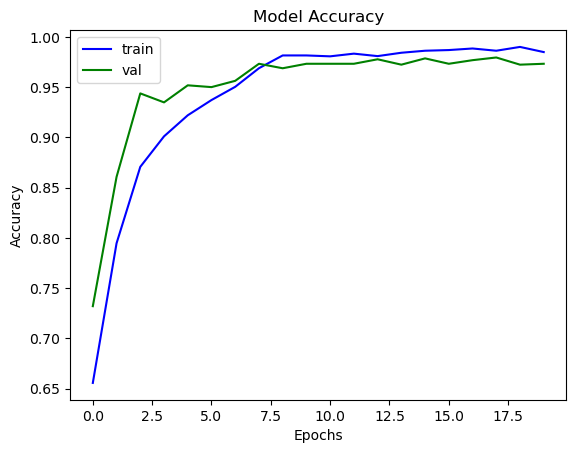

In [15]:
plt.plot(history.history['acc'], 'b')
plt.plot(history.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

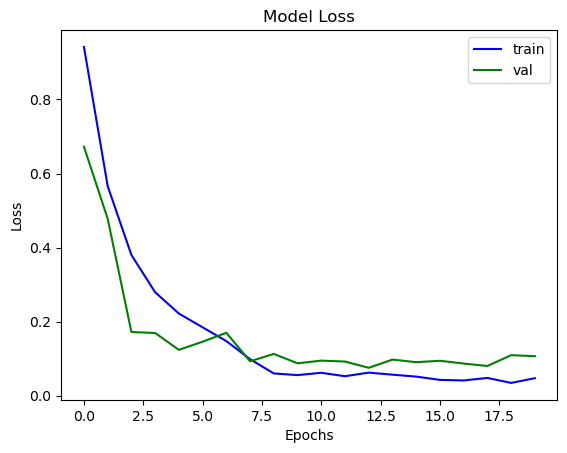

In [16]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

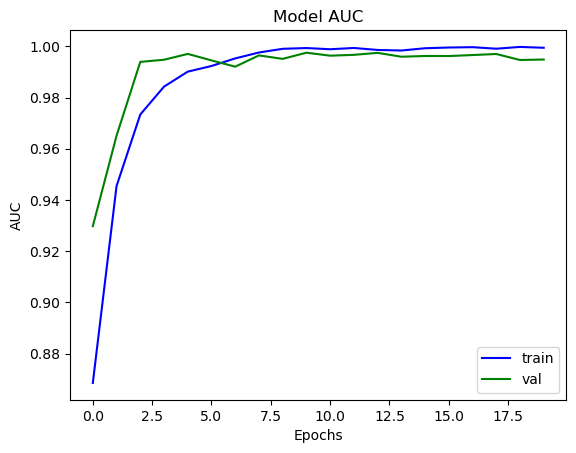

In [17]:
plt.plot(history.history['auc'], 'b')
plt.plot(history.history['val_auc'], 'g')
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["train", "val"])
plt.show()

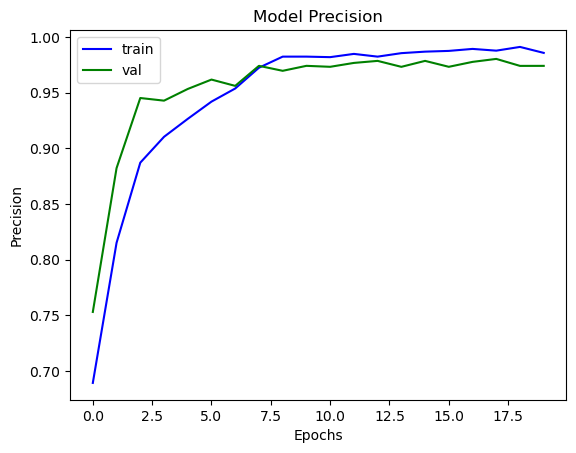

In [18]:
plt.plot(history.history['precision'], 'b')
plt.plot(history.history['val_precision'], 'g')
plt.title("Model Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["train", "val"])
plt.show()

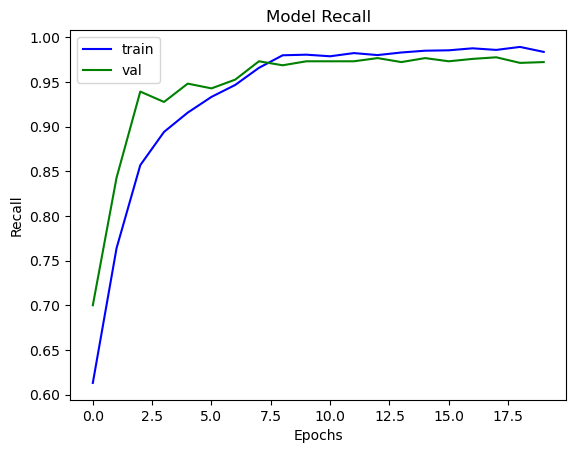

In [19]:
plt.plot(history.history['recall'], 'b')
plt.plot(history.history['val_recall'], 'g')
plt.title("Model Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["train", "val"])
plt.show()

In [20]:
del history #no more required

In [21]:
pred_labels = InceptionV3_model.predict(x_test, batch_size=4)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

# Apply rounding to each set of predicted labels
rounded_pred_labels = [roundoff(labels) for labels in pred_labels]

print(classification_report(y_test, rounded_pred_labels, target_names=CLASSES))

281/281 [==============================] - 7s 18ms/step
              precision    recall  f1-score   support

      glioma       0.98      0.95      0.97       262
  meningioma       0.91      0.98      0.95       260
    no_tumor       1.00      0.97      0.98       318
   pituitary       0.99      0.99      0.99       284

   micro avg       0.97      0.97      0.97      1124
   macro avg       0.97      0.97      0.97      1124
weighted avg       0.97      0.97      0.97      1124
 samples avg       0.97      0.97      0.97      1124



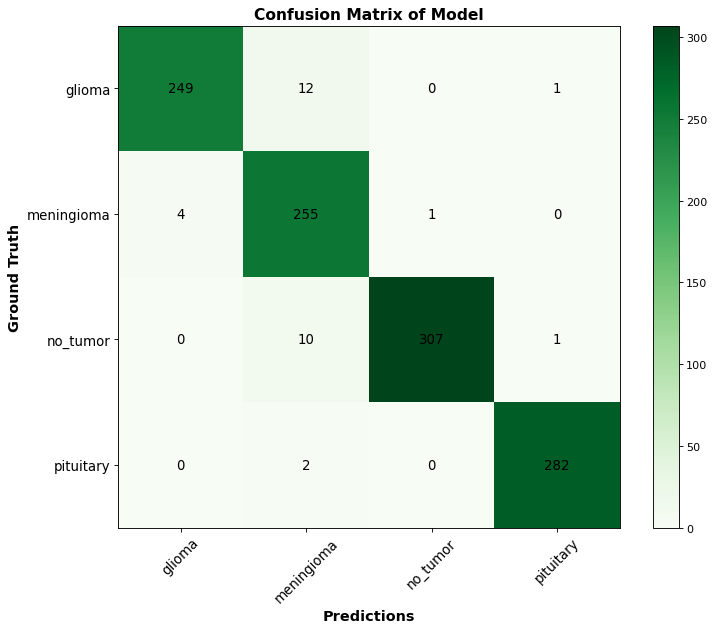

In [22]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

# Assuming pred_ls and test_ls are already defined
conf_arr = confusion_matrix(test_ls, pred_ls)

# Plotting the confusion matrix using matplotlib
plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

# Create a grid of subplots (1 row x 1 column)
ax = plt.subplot(111)

# Show the matrix using imshow
cax = ax.imshow(conf_arr, interpolation='nearest', cmap='Greens')

# Add a color bar
plt.colorbar(cax)

# Add title and axis labels
plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)

# Define the tick marks
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45, fontsize=12)
plt.yticks(tick_marks, CLASSES, fontsize=12)

# Annotate each cell with the numeric values
for i in range(conf_arr.shape[0]):
    for j in range(conf_arr.shape[1]):
        plt.text(j, i, str(conf_arr[i, j]), horizontalalignment="center", verticalalignment="center", color="black", fontsize=12)

# Adjust layout to ensure everything fits without overlap
plt.tight_layout()

# Show the plot
plt.show()


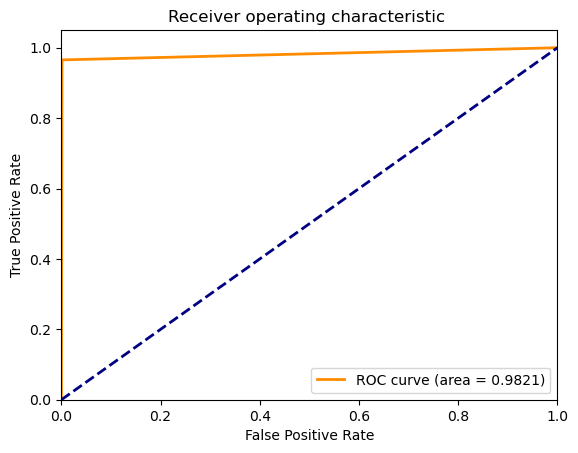

In [23]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

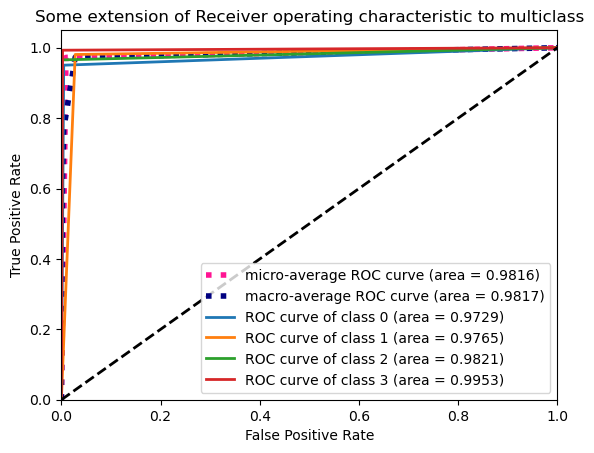

In [24]:
n_classes = 4
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.4f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.4f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

# ResNet50 Model

In [25]:
# Load the ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(170, 170, 3))

# Create a new model on top of the base ResNet50 model
ResNet50_model = Sequential()

# Add the ResNet50 base model
ResNet50_model.add(base_model)

ResNet50_model.add(Dropout(0.10))

ResNet50_model.add(Flatten())

ResNet50_model.add(BatchNormalization())
ResNet50_model.add(Dense(768, activation='relu'))
ResNet50_model.add(Dropout(0.30))

ResNet50_model.add(Dense(384, activation='relu'))
ResNet50_model.add(Dropout(0.30))

ResNet50_model.add(Dense(4, activation='softmax'))

base_model.summary()

ResNet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 170, 170, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 176, 176, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 85, 85, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 85, 85, 64)   256         ['conv1_conv[0][0]']      

In [26]:
### Model Compilation
ResNet50_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [27]:
# callbacks used in model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

In [28]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8

history = ResNet50_model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 20,
batch_size=batch_size,
callbacks=CALLBACKS
)

Epoch 1/20
561/561 [==============================] - 60s 97ms/step - loss: 0.8451 - acc: 0.7343 - auc: 0.9092 - precision: 0.7566 - recall: 0.7082 - val_loss: 2.6546 - val_acc: 0.3071 - val_auc: 0.5585 - val_precision: 0.3343 - val_recall: 0.2982 - lr: 0.0100
Epoch 2/20
561/561 [==============================] - 53s 95ms/step - loss: 0.3511 - acc: 0.8796 - auc: 0.9772 - precision: 0.8870 - recall: 0.8676 - val_loss: 0.2763 - val_acc: 0.8866 - val_auc: 0.9865 - val_precision: 0.8984 - val_recall: 0.8768 - lr: 0.0100
Epoch 3/20
561/561 [==============================] - 53s 95ms/step - loss: 0.2551 - acc: 0.9126 - auc: 0.9870 - precision: 0.9216 - recall: 0.9035 - val_loss: 0.4150 - val_acc: 0.8759 - val_auc: 0.9740 - val_precision: 0.8862 - val_recall: 0.8687 - lr: 0.0100
Epoch 4/20
561/561 [==============================] - 54s 96ms/step - loss: 0.1949 - acc: 0.9305 - auc: 0.9921 - precision: 0.9355 - recall: 0.9242 - val_loss: 0.1485 - val_acc: 0.9589 - val_auc: 0.9948 - val_precisio

In [29]:
ResNet50_model.save('./ResNet50_SGD.h5')

In [30]:
test_scores = ResNet50_model.evaluate(x_test, y_test, batch_size = 4)

precision = test_scores[3]
recall = test_scores[4]

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))


281/281 [==============================] - 7s 23ms/step - loss: 0.0691 - acc: 0.9831 - auc: 0.9969 - precision: 0.9831 - recall: 0.9831
Testing Accuracy: 	 98.309606 %
Testing AC: 		 99.687672 %
Testing Precision: 	 98.309606 %
Testing Recall: 	 98.309606 %
Testing F1-Score: 	 98.309606 %


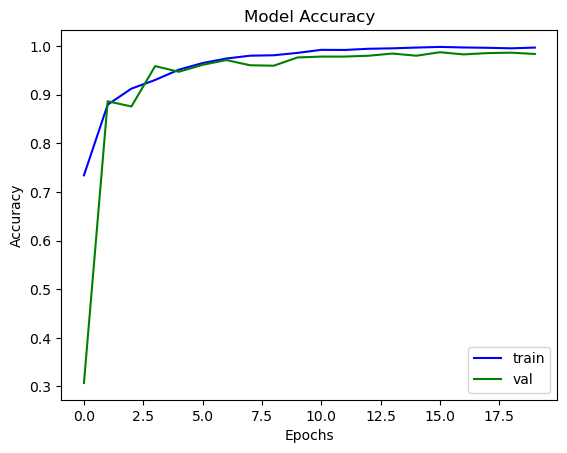

In [31]:
plt.plot(history.history['acc'], 'b')
plt.plot(history.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

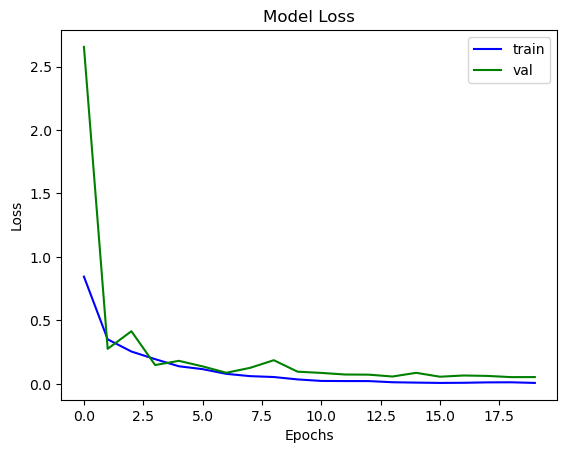

In [32]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

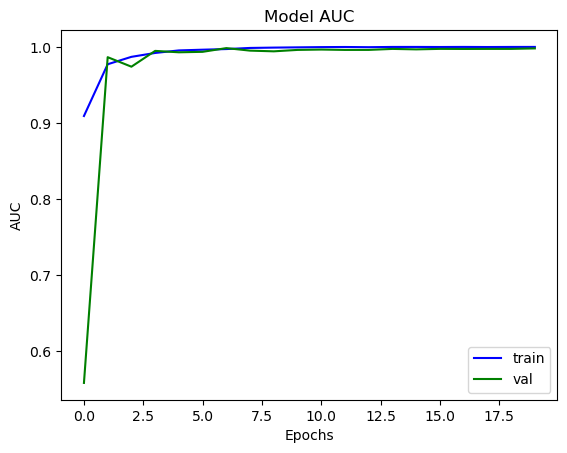

In [33]:
plt.plot(history.history['auc'], 'b')
plt.plot(history.history['val_auc'], 'g')
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["train", "val"])
plt.show()

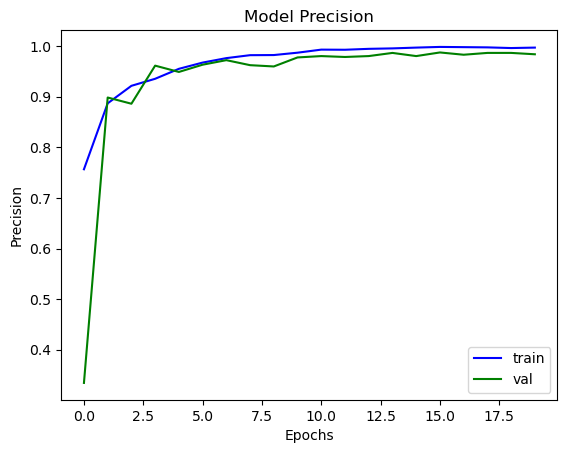

In [34]:
plt.plot(history.history['precision'], 'b')
plt.plot(history.history['val_precision'], 'g')
plt.title("Model Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["train", "val"])
plt.show()

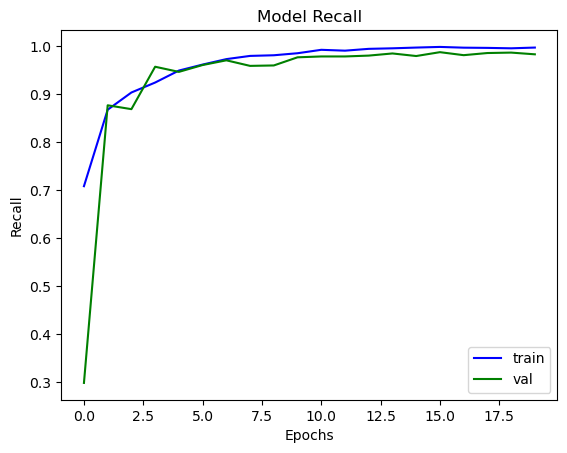

In [35]:
plt.plot(history.history['recall'], 'b')
plt.plot(history.history['val_recall'], 'g')
plt.title("Model Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["train", "val"])
plt.show()

In [36]:
del history #no more required

In [37]:
pred_labels = ResNet50_model.predict(x_test, batch_size=4)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

# Apply rounding to each set of predicted labels
rounded_pred_labels = [roundoff(labels) for labels in pred_labels]

print(classification_report(y_test, rounded_pred_labels, target_names=CLASSES))

281/281 [==============================] - 6s 17ms/step
              precision    recall  f1-score   support

      glioma       0.98      0.96      0.97       262
  meningioma       0.96      0.98      0.97       260
    no_tumor       1.00      1.00      1.00       318
   pituitary       0.99      0.99      0.99       284

   micro avg       0.98      0.98      0.98      1124
   macro avg       0.98      0.98      0.98      1124
weighted avg       0.98      0.98      0.98      1124
 samples avg       0.98      0.98      0.98      1124



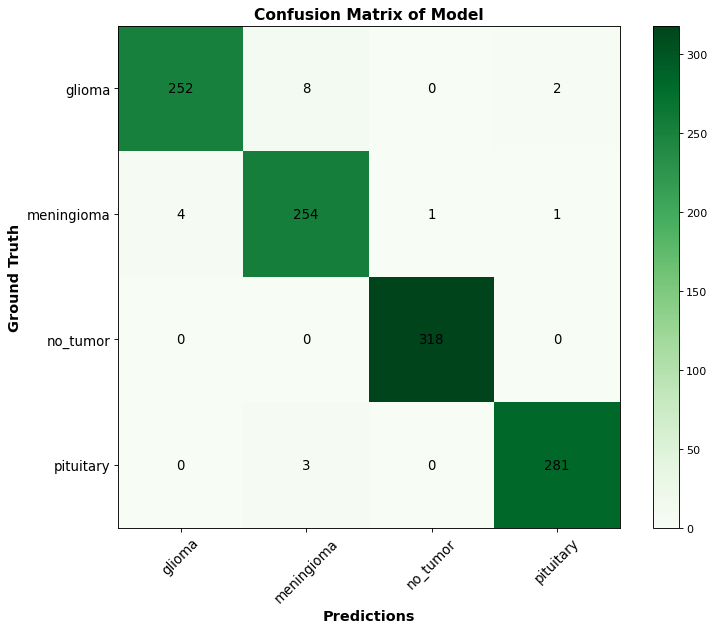

In [38]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

# Assuming pred_ls and test_ls are already defined
conf_arr = confusion_matrix(test_ls, pred_ls)

# Plotting the confusion matrix using matplotlib
plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

# Create a grid of subplots (1 row x 1 column)
ax = plt.subplot(111)

# Show the matrix using imshow
cax = ax.imshow(conf_arr, interpolation='nearest', cmap='Greens')

# Add a color bar
plt.colorbar(cax)

# Add title and axis labels
plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)

# Define the tick marks
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45, fontsize=12)
plt.yticks(tick_marks, CLASSES, fontsize=12)

# Annotate each cell with the numeric values
for i in range(conf_arr.shape[0]):
    for j in range(conf_arr.shape[1]):
        plt.text(j, i, str(conf_arr[i, j]), horizontalalignment="center", verticalalignment="center", color="black", fontsize=12)

# Adjust layout to ensure everything fits without overlap
plt.tight_layout()

# Show the plot
plt.show()


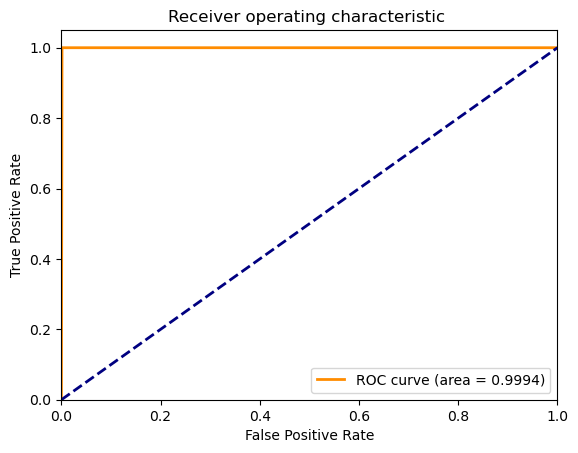

In [39]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

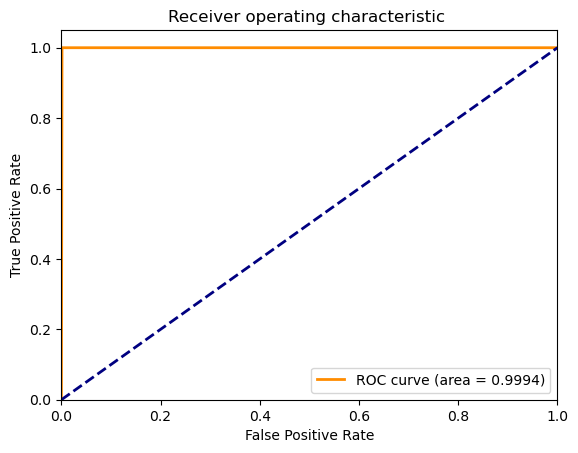

In [40]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

# VGG19 Model

In [41]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(170, 170, 3))

# Create a new model on top of the base VGG19 model
VGG19_model = Sequential()

# Add the VGG19 base model
VGG19_model.add(base_model)

VGG19_model.add(Dropout(0.10))

VGG19_model.add(Flatten())

VGG19_model.add(BatchNormalization())
VGG19_model.add(Dense(768, activation='relu'))
VGG19_model.add(Dropout(0.30))

VGG19_model.add(Dense(384, activation='relu'))
VGG19_model.add(Dropout(0.30))

VGG19_model.add(Dense(4, activation='softmax'))

base_model.summary()

VGG19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 170, 170, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 170, 170, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 170, 170, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 85, 85, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 85, 85, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 85, 85, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 42, 42, 128)       0     

In [42]:
### Model Compilation
VGG19_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [43]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8

history = VGG19_model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 20,
batch_size=batch_size,
callbacks=CALLBACKS
)

Epoch 1/20
561/561 [==============================] - 95s 156ms/step - loss: 0.9609 - acc: 0.6057 - auc: 0.8479 - precision: 0.6709 - recall: 0.5167 - val_loss: 1.4779 - val_acc: 0.4545 - val_auc: 0.7759 - val_precision: 0.4586 - val_recall: 0.4402 - lr: 0.0100
Epoch 2/20
561/561 [==============================] - 84s 149ms/step - loss: 0.6959 - acc: 0.7399 - auc: 0.9191 - precision: 0.7768 - recall: 0.6797 - val_loss: 1.9407 - val_acc: 0.3848 - val_auc: 0.7175 - val_precision: 0.3961 - val_recall: 0.3589 - lr: 0.0100
Epoch 3/20
561/561 [==============================] - 83s 148ms/step - loss: 0.5803 - acc: 0.7840 - auc: 0.9422 - precision: 0.8155 - recall: 0.7488 - val_loss: 2.2389 - val_acc: 0.4393 - val_auc: 0.7580 - val_precision: 0.4410 - val_recall: 0.4375 - lr: 0.0100
Epoch 4/20
561/561 [==============================] - 83s 148ms/step - loss: 0.4286 - acc: 0.8422 - auc: 0.9669 - precision: 0.8632 - recall: 0.8128 - val_loss: 0.3030 - val_acc: 0.8955 - val_auc: 0.9838 - val_prec

In [44]:
VGG19_model.save('./VGG19_SGD.h5')

In [45]:
test_scores = VGG19_model.evaluate(x_test, y_test, batch_size = 4)

precision = test_scores[3]
recall = test_scores[4]

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))


281/281 [==============================] - 8s 26ms/step - loss: 0.1819 - acc: 0.9368 - auc: 0.9931 - precision: 0.9431 - recall: 0.9297
Testing Accuracy: 	 93.683273 %
Testing AC: 		 99.307495 %
Testing Precision: 	 94.314080 %
Testing Recall: 	 92.971528 %
Testing F1-Score: 	 93.637992 %


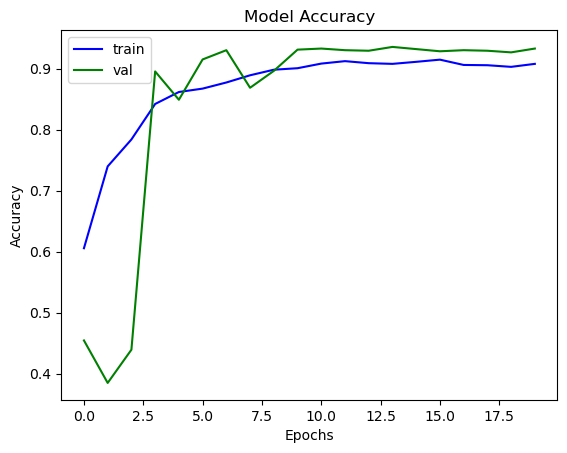

In [46]:
plt.plot(history.history['acc'], 'b')
plt.plot(history.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

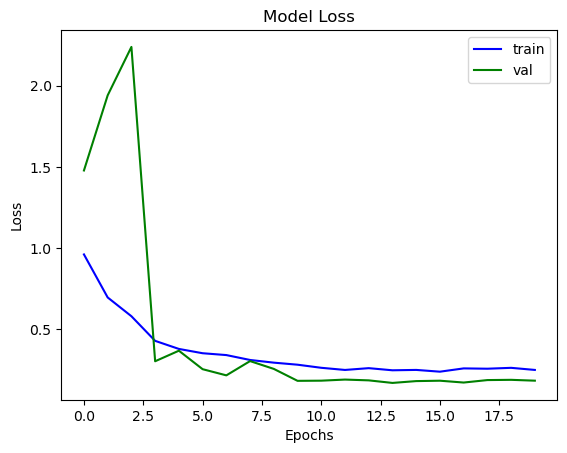

In [47]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

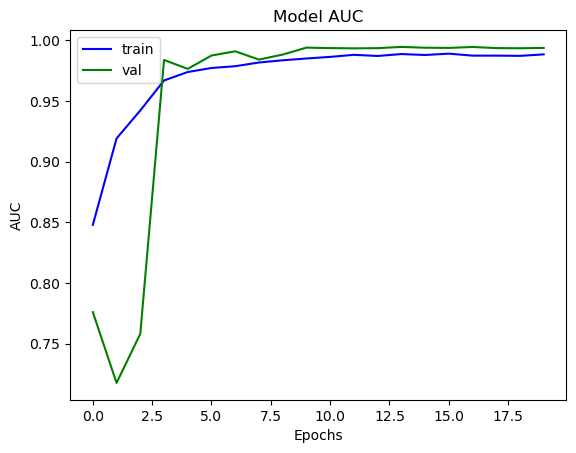

In [48]:
plt.plot(history.history['auc'], 'b')
plt.plot(history.history['val_auc'], 'g')
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["train", "val"])
plt.show()

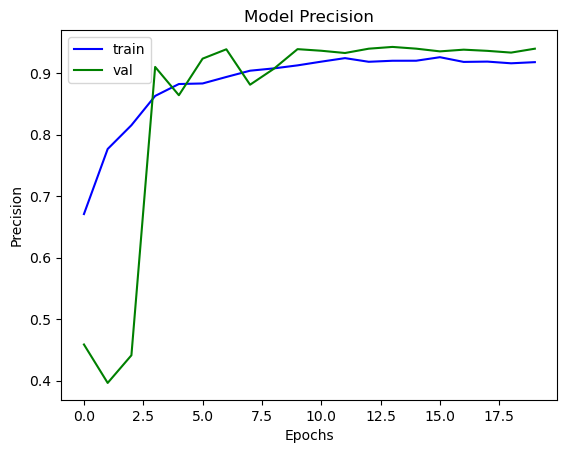

In [49]:
plt.plot(history.history['precision'], 'b')
plt.plot(history.history['val_precision'], 'g')
plt.title("Model Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["train", "val"])
plt.show()

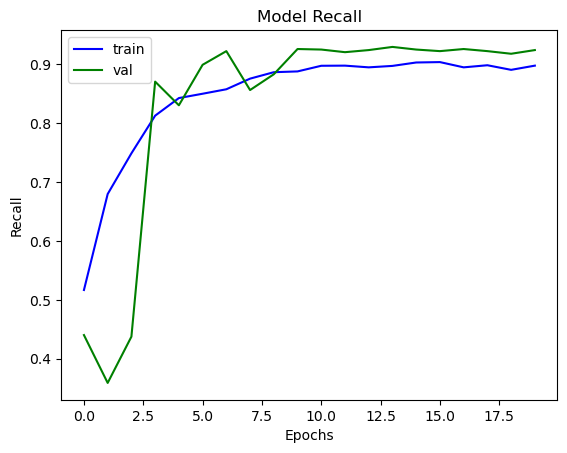

In [50]:
plt.plot(history.history['recall'], 'b')
plt.plot(history.history['val_recall'], 'g')
plt.title("Model Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["train", "val"])
plt.show()

In [51]:
del history #no more required

In [52]:

pred_labels = VGG19_model.predict(x_test, batch_size=4)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

# Apply rounding to each set of predicted labels
rounded_pred_labels = [roundoff(labels) for labels in pred_labels]

print(classification_report(y_test, rounded_pred_labels, target_names=CLASSES))


281/281 [==============================] - 7s 23ms/step
              precision    recall  f1-score   support

      glioma       0.94      0.93      0.93       262
  meningioma       0.92      0.82      0.87       260
    no_tumor       0.96      0.99      0.98       318
   pituitary       0.92      0.99      0.95       284

   micro avg       0.94      0.94      0.94      1124
   macro avg       0.94      0.93      0.93      1124
weighted avg       0.94      0.94      0.94      1124
 samples avg       0.94      0.94      0.94      1124



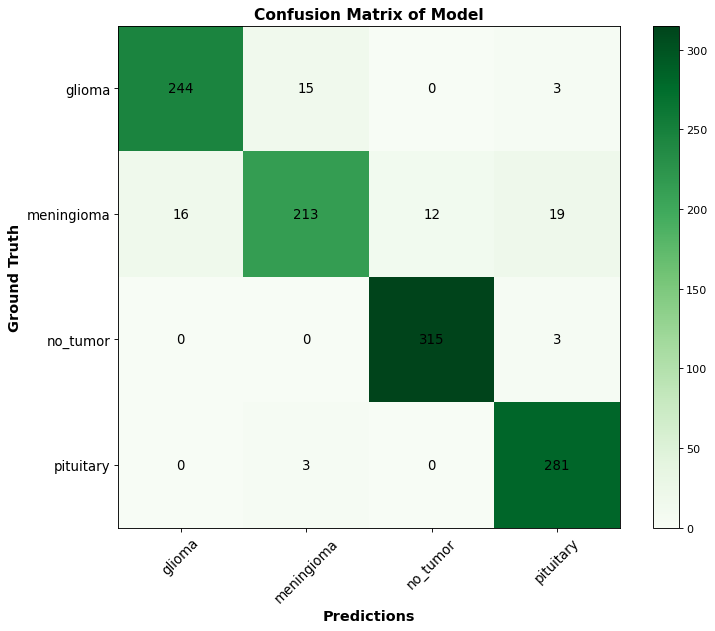

In [53]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

# Assuming pred_ls and test_ls are already defined
conf_arr = confusion_matrix(test_ls, pred_ls)

# Plotting the confusion matrix using matplotlib
plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

# Create a grid of subplots (1 row x 1 column)
ax = plt.subplot(111)

# Show the matrix using imshow
cax = ax.imshow(conf_arr, interpolation='nearest', cmap='Greens')

# Add a color bar
plt.colorbar(cax)

# Add title and axis labels
plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)

# Define the tick marks
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45, fontsize=12)
plt.yticks(tick_marks, CLASSES, fontsize=12)

# Annotate each cell with the numeric values
for i in range(conf_arr.shape[0]):
    for j in range(conf_arr.shape[1]):
        plt.text(j, i, str(conf_arr[i, j]), horizontalalignment="center", verticalalignment="center", color="black", fontsize=12)

# Adjust layout to ensure everything fits without overlap
plt.tight_layout()

# Show the plot
plt.show()


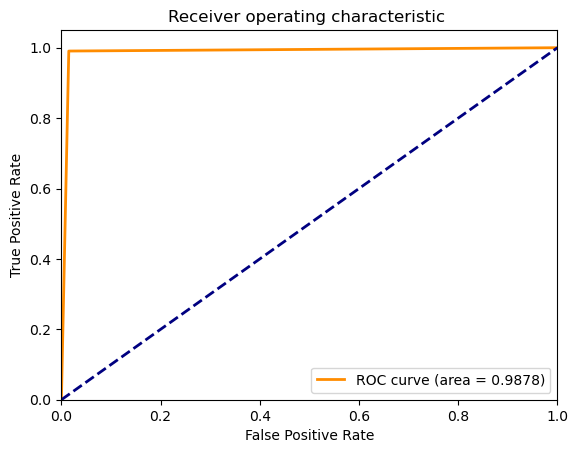

In [54]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

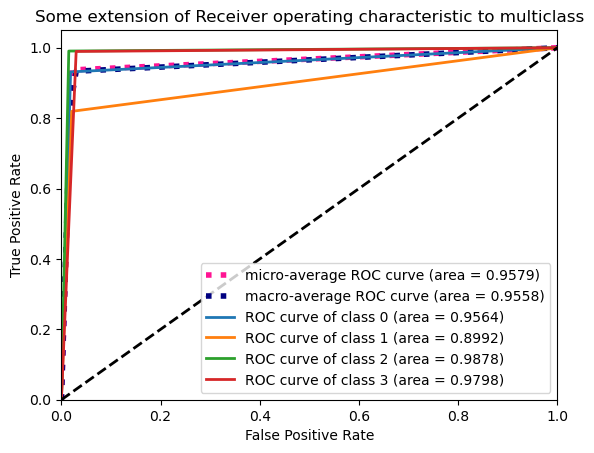

In [55]:
n_classes = 4
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.4f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.4f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()